# Heatwave hazard assessment using PESETA IV methodology

## Description of the assessment

In this workflow we will assess the heatwave hazard based on the methodology used in the [PESETA IV project](https://joint-research-centre.ec.europa.eu/peseta-projects/jrc-peseta-iv_en).  

In this approach, a heatwave is defined as a period of three or more consecutive days with a maximum temperature above a daily threshold. The threshold temperature is defined as the 90th percentile of daily maximum temperature, centered on a 31-day window (1 month), which is calculated based on a historical 30-year reference period (for testing in this workflow we choose a shorter period). At least 30 years of daily temperature timeseries are needed to obtain a robust estimation of the heatwave occurence. 

The hazard calculation is based on climate data with resolution of 12x12km (EURO-CORDEX) with data available for 1971-2100.

**Advantages of using this methodology:**
- Allows for the estimation of the yearly and monthly (seasonal) heatwave occurence
- Flexibility of the methodology: the possibility of changing the temperature threshold (eg. 90 percentile)
- The threshold is estimated for each grid cell in the climate dataset (12x12km) and is based on location-specific historical temperature conditions.
- This methodology is better for estimating the occurence of heatwave events not only for the summer months but also in other seasons, because thresholds are calculated separately for different times in a year. This allows to detect the season-specific changes.

**Disadvantages:**
- Computationally intensive due to the large amount of data.
- Methodology does not take into account variations in the minimum daily temperature. This can be a shortcoming in e.g. mountainous regions where there are large differences between the day and night temperatures.

## Step 1: Preparation work

### Import packages

:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Provides tools for creating, reading, writing, and extracting ZIP files.
* [os](https://docs.python.org/3/library/os.html) - Provides functions for interacting with the operating system, such as file and directory manipulation.
* [glob](https://docs.python.org/3/library/glob.html) - Unix style pathname pattern expansion.
* [itertools](https://docs.python.org/3/library/itertools.html) - Functions for creating iterators forefficient looping.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - A library for reading and writing geospatial raster data.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - A library to request data from the datasets listed in the CDS catalogue.
* [numpy](https://numpy.org/doc/stable/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [dask](https://docs.dask.org/en/stable/index.html) - Efficient handling of large datasets and computations.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - A package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
* [matplotlib](https://matplotlib.org/stable/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [plotly](https://plotly.com/) - A Python Graphing Library.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Enables interactive maps in Jupyter notebooks using the Leaflet.js library.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Provides interactive HTML widgets for Jupyter notebooks.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Serves local raster tiles for visualization in Leaflet maps.


In [1]:
import zipfile
import os
from glob import glob
from itertools import chain

import cdsapi
import numpy as np
import xarray as xr
import rasterio
from dask.diagnostics import ProgressBar 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly.graph_objects as go
from ipyleaflet import Map, DrawControl, Marker, LayersControl
import ipywidgets as widgets
from localtileserver import get_leaflet_tile_layer, TileClient

In [2]:
# Set host forwarding for remote jupyterlab sessions
if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ:
    os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = f"{os.environ['JUPYTERHUB_SERVICE_PREFIX']}/proxy/{{port}}"

### Create directory structure

In [2]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heatwave_hazard_PesetaIV'
# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')
r1971_2000_dir = os.path.join(workflow_folder,'r1971_2000')
r85_2011_2040_dir = os.path.join(workflow_folder,'r85_2011_2040')
r85_2041_2070_dir = os.path.join(workflow_folder,'r85_2041_2070')
r85_2071_2100_dir = os.path.join(workflow_folder,'r85_2071_2100')
r45_2011_2040_dir = os.path.join(workflow_folder,'r45_2011_2040')
r45_2041_2070_dir = os.path.join(workflow_folder,'r45_2041_2070')
r45_2071_2100_dir = os.path.join(workflow_folder,'r45_2071_2100')
# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))
    os.makedirs(os.path.join(r1971_2000_dir))
    os.makedirs(os.path.join(r85_2011_2040_dir))
    os.makedirs(os.path.join(r85_2041_2070_dir))
    os.makedirs(os.path.join(r85_2071_2100_dir))
    os.makedirs(os.path.join(r45_2011_2040_dir))
    os.makedirs(os.path.join(r45_2041_2070_dir))
    os.makedirs(os.path.join(r45_2071_2100_dir))

## Step 2: Retrieving data

We need to download the daily maximum air temperature at 2m height from the EURO-CORDEX dataset. The code below will download this data for the selected period and RCP scenario.
- In the code below you can find information about selected locations, resolutions, models, periods, etc.
- More information about the **data** you can find [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form)
- More information about **RCP** scenarios can be found [here](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway)

We can download data from the CDS with the API. If this is the first time you do this, you will need to register on CDS and set your API key. Check [[How to change your API KEY](https://cds.climate.copernicus.eu/api-how-to)] and change the KEY in the code cell below.

In [3]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = None # put your key here

c = cdsapi.Client(url=URL, key=KEY)

**Important:** we will only download data for a single combination of GCM and RCM models. Below you can specify which combination you would like to use. For a more reliable result of the assessment, it is recommended to make the analysis for several combinations of GCM-RCM. For an overview of available combinations see the [CDS download form](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cordex-domains-single-levels?tab=form) and [documentation on GCM-RCM models](https://confluence.ecmwf.int/display/CKB/CORDEX%3A+Regional+climate+projections#heading-DrivingGlobalClimateModelsandRegionalClimateModels).

In [1]:
gcm_model = 'cnrm_cerfacs_cm5'
rcm_model = 'clmcom_clm_cclm4_8_17'

First we download the daily maximum 2m temperature for 1971-2000.

In [9]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurminmax_1971_2000.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'historical',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': gcm_model,
        'rcm_model': rcm_model,
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '1971', '1976', '1981', '1986', '1991', '1996', 
        ],
        'end_year': [
            '1975', '1980', '1985', '1990', '1995', '2000', 
        ],
    },
    zip_path)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

2024-06-28 16:16:20,286 INFO Welcome to the CDS
2024-06-28 16:16:20,287 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-06-28 16:16:20,428 INFO Request is queued
2024-06-28 16:16:21,500 INFO Request is running
2024-06-28 16:28:39,913 INFO Request is completed
2024-06-28 16:28:39,963 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data7/dataset-projections-cordex-domains-single-levels-bbd1da20-9898-4bce-91cb-bada1af556a2.zip to Heatwave_hazard_PesetaIV\data/era5_daily_t2m_eurminmax_1971_2000.zip (3.9G)
2024-06-28 16:38:21,672 INFO Download rate 6.9M/s   


Next we download the daily maximum temperature at 2m for RCP8.5, 2011-2100
(or you can select other suggested period 2041-2070, 2071-2100, RCP4.5 or RCP8.5)

In [ ]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurminmax_2011_2100.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_8_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': gcm_model,
        'rcm_model': rcm_model,
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
    zip_path)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

2024-07-08 18:35:04,354 INFO Welcome to the CDS
2024-07-08 18:35:04,355 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-07-08 18:35:04,504 INFO Request is queued
2024-07-08 18:35:05,543 INFO Request is running
2024-07-08 18:59:24,066 INFO Request is completed
2024-07-08 18:59:24,105 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data1/dataset-projections-cordex-domains-single-levels-aa2ecfc6-66d3-4f75-ab1d-638ac263d8fd.zip to Heatwave_hazard_PesetaIV\data/era5_daily_t2m_eurminmax_2011_2100.zip (11.7G)
 17%|█████████████▏                                                               | 2.01G/11.7G [08:07<35:32, 4.89MB/s]

Next we download the daily maximum temperature at 2m for RCP4.5, 2011-2100:

In [4]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir, 'eurocordex_daily_t2m_eurmax_rcp45_2011_2100.zip')

# Download the data for the selected time-period and RCP
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'format': 'zip',
        'domain': 'europe',
        'experiment': 'rcp_4_5',
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': 'maximum_2m_temperature_in_the_last_24_hours',
        'gcm_model': gcm_model,
        'rcm_model': rcm_model,
        'ensemble_member': 'r1i1p1',
        'start_year': [
            '2011', '2016', '2021', '2026', '2031', '2036', '2041', '2046', '2051', '2056', '2061', '2066', '2071', '2076', '2081', '2086', '2091', '2096',
        ],
        'end_year': [
            '2015', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100',
        ],
    },
    zip_path)

# Unzip the downloaded files so they are ready for computing 
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir)

# Remove the downloaded zip file after unpacking
os.remove(zip_path)

2024-07-09 15:13:19,632 INFO Welcome to the CDS
2024-07-09 15:13:19,642 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cordex-domains-single-levels
2024-07-09 15:13:19,968 INFO Request is queued
2024-07-09 15:13:21,038 INFO Request is running
2024-07-09 15:51:42,960 INFO Request is completed
2024-07-09 15:51:43,082 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data2/dataset-projections-cordex-domains-single-levels-ddc2627b-2129-46a2-afe9-b91a75c2ed0f.zip to Heatwave_hazard_PesetaIV\data/era5_daily_t2m_eurmax_rcp45_2011_2100.zip (11.7G)
2024-07-09 16:33:59,797 INFO Download rate 4.7M/s     


Result(content_length=12592570100,content_type=application/zip,location=https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data2/dataset-projections-cordex-domains-single-levels-ddc2627b-2129-46a2-afe9-b91a75c2ed0f.zip)

## Step 3: analyze the data

### Load data and convert Kelvin to Celsius

Load data from your working directory, and set the coordinates system (CRS)

In [6]:
# Historical data Maximum temperature
dmaxh = xr.open_mfdataset(f'{data_dir}/tasmax*historical*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmaxh.rio.write_crs(rotated_pole, inplace=True)

# Maximum temperature rcp 4.5
dmax45 = xr.open_mfdataset(f'{data_dir}/tasmax*rcp45*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax45.rio.write_crs(rotated_pole, inplace=True)

# Maximum temperature rcp 8.5
dmax85 = xr.open_mfdataset(f'{data_dir}/tasmax*rcp85*.nc', decode_coords='all')
rotated_pole = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
dmax85.rio.write_crs(rotated_pole, inplace=True)

print("Data loaded and crs has been set")

Data loaded and crs has been set


### Selection of the region of interest

**Tip for the selection of the area:**
Select at least the area of the region or state where you want to assess the heatwave hazard (bigger area is better for graphical comparison, for EURO-CORDEX resolution of 12x12km)
- "Zoom" to your area with [+] (top left corner)
- "Click" on the rectangle on the left panel
- "Select your area" by left click and drag
-  And run a code below which "automatically" takes the coordinates of your area and transforms it to rotated pole CRS which is used by the EuroCordex data

In [ ]:
# This code plots a map where you need to select a bounding box, as an area for the heatwave estimation
# Create a map centered at a specific location
m = Map(center=(0, 0), zoom=2)
# Create lists to store rectangle coordinates
min_lon_list = []
min_lat_list = []
max_lon_list = []
max_lat_list = []
# Create a DrawControl with rectangle drawing enabled
draw_control = DrawControl(rectangle={'shapeOptions': {'color': '#ff0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Polygon':
            # Extract coordinates of the rectangle
            coords = geo_json['geometry']['coordinates'][0]
            # Compute rectangle coordinates (min_lon, min_lat, max_lon, max_lat)
            min_lon, min_lat = min(coord[0] for coord in coords), min(coord[1] for coord in coords)
            max_lon, max_lat = max(coord[0] for coord in coords), max(coord[1] for coord in coords)
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({min_lon:.2f}, {min_lat:.2f}), ({max_lon:.2f}, {max_lat:.2f})'
            # Append coordinates to lists
            min_lon_list.append(min_lon)
            min_lat_list.append(min_lat)
            max_lon_list.append(max_lon)
            max_lat_list.append(max_lat)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

Note: the coordinates will be automatically taken to next steps, you do not need to copy them!

In [6]:
# This code extracts the coordinates from the bounding box selected above and transform it to Rotated pole coordinates
a=min_lon_list + min_lat_list
b=max_lon_list + max_lat_list
# Define the source and destination coordinate reference systems
source_crs = ccrs.PlateCarree()  # WGS84 CRS
#dest_crs = ccrs.RotatedPole(pole_longitude=190, pole_latitude=39.25, central_rotated_longitude=0)
dest_crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
# Example coordinates in WGS 84
#wgs84_coords = [(18.528168, 49.076529), (18.965041, 49.349247)]
wgs84_coords = [(a), (b)]
# Perform the transformation for each pair of coordinates
rotated_pole_coords = []
for lon, lat in wgs84_coords:
    rotated_pole_coords.append(dest_crs.transform_point(lon, lat, source_crs))
print("WGS 84 Coordinates:", wgs84_coords)
print("Rotated Pole Coordinates:", rotated_pole_coords)

WGS 84 Coordinates: [[4.232483, 52.010246], [4.43573, 52.125058]]
Rotated Pole Coordinates: [(np.float64(-8.428593492369622), np.float64(2.045221059630215)), (np.float64(-8.284647659185556), np.float64(2.1352180634217377))]


In [7]:
# This code will create a list from the coordinates in WGS84
# Original list of tuples
list_of_tuples = wgs84_coords
# Convert the list of tuples to a single tuple
bbox84 = tuple(chain.from_iterable(list_of_tuples))
print(bbox84)

(4.232483, 52.010246, 4.43573, 52.125058)


In [8]:
# This code will create a list from the coordinates in rotated pole
# Original list of tuples
list_of_tuples2 = rotated_pole_coords
# Convert the list of tuples to a single tuple
bbox = tuple(chain.from_iterable(list_of_tuples2))
print(bbox)

(np.float64(-8.428593492369622), np.float64(2.045221059630215), np.float64(-8.284647659185556), np.float64(2.1352180634217377))


### Clip data to the region of interest
The bouding box coordinates will be automatically copied after a selection of the bbox

In [11]:
# This code crops the downloaded data from CDS to your selected bounding box (selected area)
dmaxch = dmaxh.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmaxc45 = dmax45.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  
dmaxc85 = dmax85.rio.clip_box(minx=bbox[0], miny=bbox[1], maxx=bbox[2], maxy=bbox[3])  

Convert the maximum temperature data from Kelvin (K) to Celsius (°C).

In [12]:
# Max Temperature historical
dmaxch = dmaxch['tasmax']
tasmaxh = dmaxch - 273.15
tasmaxh = tasmaxh.assign_attrs(dmaxch.attrs)
tasmaxh.attrs['units']='°C'

# Max Temperature rcp 45
dmaxc45 = dmaxc45['tasmax']
tasmax45 = dmaxc45 - 273.15
tasmax45 = tasmax45.assign_attrs(dmaxc45.attrs)
tasmax45.attrs['units']='°C'

# Max Temperature rcp 85
dmaxc85 = dmaxc85['tasmax']
tasmax85 = dmaxc85 - 273.15
tasmax85 = tasmax85.assign_attrs(dmaxc85.attrs)
tasmax85.attrs['units']='°C'

# Select a time period for maximum temperature
# Max T
tasmaxh = tasmaxh.sel(time=slice("1971-01-01", "2000-12-31"))
tasmaxp1_45 = tasmax45.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2_45 = tasmax45.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3_45 = tasmax45.sel(time=slice("2071-01-01", "2100-12-31"))
tasmaxp1_85 = tasmax85.sel(time=slice("2011-01-01", "2040-12-31"))
tasmaxp2_85 = tasmax85.sel(time=slice("2041-01-01", "2070-12-31"))
tasmaxp3_85 = tasmax85.sel(time=slice("2071-01-01", "2100-12-31"))
#tasmaxp=tasmax.sel(time=slice("2011-01-01", "2100-12-31"))

### Set the temperature treshold 

Set the percentile/quantile treshold for the daily maximum air temperature e.g. 0.90 quantile = 90th percentile

In [15]:
# the treshold given by the quantile of the maximum daily air temperature for the month for 30 years. 
temperature_threshold = 0.90 # quantile (i.e. 90% percentile is 0.9 quantile)

### Define the fuction for the calculation of the number of the heatwave events

- For the extraction of the heatwave events in the future we use the 90percentile treshold from the reference period 1971-2000
- You can change the 90th percentile (treshold) for your treshold in the row ### tas_maxh90=tas_maxh.chunk(dict(time=-1)).quantile(0.90,'time')
- This will take multiple minutes (depending on the selected area, e.g. whole Catalunya = 50min)

In [ ]:
# This code calculates the heatwave occurrence for the years and months for the periods and RCP listed in the "dirs" and "years"
# Calculation of the heatwave events based on PESETA IV

print("loading reference data")
with ProgressBar():
    tasmaxh = tasmaxh.persist()

dtyy = [
    (r1971_2000_dir, tasmaxh, 1971, 2001),
    (r45_2011_2040_dir, tasmaxp1_45, 2011, 2041),
    (r45_2041_2070_dir, tasmaxp2_45, 2041, 2071),
    (r45_2071_2100_dir, tasmaxp3_45, 2071, 2101),
    (r85_2011_2040_dir, tasmaxp1_85, 2011, 2041),
    (r85_2041_2070_dir, tasmaxp2_85, 2041, 2071),
    (r85_2071_2100_dir, tasmaxp3_85, 2071, 2101)
]

# Divide the time series to months 
for d, t, start_year, end_year in dtyy:
    print("loading", d)
    with ProgressBar():
        t = t.persist()
    tasmax_month = tasmaxh.groupby('time.month').groups
    tasmax_montp1 = t.groupby('time.month').groups

    print("processing")
    # Calculate the heatwave occurence for all months in given period  
    for i in range (1, 13):
        tasmaxh_idxs = tasmax_month[i]
        tasmaxp1_idxs = tasmax_montp1[i]
        # Extract the  months by selecting the relevant indices
        tas_maxh = tasmaxh.isel(time=tasmaxh_idxs)
        tas_maxp1 = t.isel(time=tasmaxp1_idxs)      
        # based on percentile threshold
        tas_maxh90 = tas_maxh.chunk({ "time": -1 }).quantile(temperature_threshold, 'time')
        heatp1t = xr.where(tas_maxp1>tas_maxh90, 1, 0).persist()
        # Create + time dataset
        vat = heatp1t
        v1at = heatp1t[:-1,:,:]
        v2at = heatp1t[:-2,:,:]
        v3at = heatp1t[:-3,:,:]
        # Create missing days
        t1at = heatp1t[0:1,:,:]
        t2at = heatp1t[0:2,:,:]
        t3at = heatp1t[0:3,:,:]
        # Concatenate missing dates to + time dataset
        vi1at = xr.concat([t1at, v1at], dim='time')
        vi2at = xr.concat([t2at, v2at], dim='time')
        vi3at = xr.concat([t3at, v3at], dim='time')
        # Change the time dimesion for correct one
        tiat = heatp1t["time"]
        # add a time dimension
        vi1at["time"] = tiat
        vi2at["time"] = tiat
        vi3at["time"] = tiat
        # Sum of the heatwave
        sumvat = xr.where((vat==1)&(vi1at==1)&(vi2at==1), 1, 0) # count 3 day HW
        sumv2at = xr.where((vat==1)&(vi1at==1)&(vi2at==1)&(vi3at==1), -1, 0)  
        sumvatf = (sumvat+sumv2at).persist()
        sumvyp = sumvatf.groupby('time.year').groups
        for y in range(start_year, end_year):
            sat1p = sumvyp[y]
            sumt1p = sumvatf.isel(time=sat1p)
            sumyear1p = sumt1p.sum(dim='time')
            sumyear1p.rio.to_raster(raster_path=f'{d}/HW_' + str(y) + '_projYM_' + str(i) + '.tif')

print("done")

### Sum up the heatwave events by month and years and plot the results

The code below will compute the sum of the heatwave events for each month (January - December) for all selected periods in the past and the future and all RCPs:

In [11]:
# Sum of the heatwave events for months 
# List of data directory paths
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]

for d in data_dirs:
    for i in range (1,13):    
        # Read a paths for heatwaves
        HW = glob(f'{d}/*YM_' + str(i) + '.tif')
        # Create a raster stack 
        with rasterio.open(HW[0]) as src0:
            meta = src0.meta
        meta.update(count = len(HW))
        #
        with rasterio.open(f'{d}/stackHWEUM_' + str(i) + '.tif','w', **meta) as dst:
            for id, layer in enumerate(HW, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
        #
    for i in range (1, 13):    
        HWEUpm=f'{d}/stackHWEUM_' + str(i) + '.tif'
        HWEUpm= xr.open_dataset(HWEUpm)
        HWEUpm=HWEUpm.sum(dim='band', skipna=True,  keep_attrs=True)
        HWEUpm=HWEUpm['band_data']
        HWEUpm.rio.to_raster(raster_path=f'{d}/HWsumM_' + str(i) + '.tif')
    #
    HW = sorted (glob(f'{d}/HWsumM_*'), key=os.path.getmtime)
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{d}/HWsumM.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

This code will compute the sum of the heatwave events for each period for all RCPs:

In [4]:
# Sum of the heatwave events for years 
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
years = [(1971,2001),(2011,2041),(2041,2071),(2071,2101),(2011,2041),(2041,2071),(2071,2101)]

for d, year_range in zip(data_dirs, years):
    start_year, end_year = year_range
    for i in range(start_year, end_year):      
        # Read a paths for heatwaves
        HW = glob(f'{d}/HW_' + str(i) + '*')
        # Create a raster stack 
        with rasterio.open(HW[0]) as src0:
            meta = src0.meta
        #
        meta.update(count = len(HW))
        #
        with rasterio.open(f'{d}/stackHWEUY_' + str(i) + '.tif','w', **meta) as dst:
            for id, layer in enumerate(HW, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
    ##################################################
    for i in range(start_year, end_year):    
        HWEUp=f'{d}/stackHWEUY_' + str(i) + '.tif'
        HWEUp= xr.open_dataset(HWEUp)
        HWEUp=HWEUp.sum(dim='band', skipna=True,  keep_attrs=True)
        HWEUp=HWEUp['band_data']
        HWEUp.rio.to_raster(raster_path=f'{d}/HWsumY_' + str(i) + '.tif')
    ##################################################
    # Read a paths for heatwaves
    HW = sorted (glob(f'{d}/HWsumY_*'), key=os.path.getmtime)
    # Create a raster stack 
    with rasterio.open(HW[0]) as src0:
        meta = src0.meta
    #
    meta.update(count = len(HW))
    #
    with rasterio.open(f'{d}/HWsumY.tif','w', **meta) as dst:
        for id, layer in enumerate(HW, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))  

### Reproject the rasters to WGS84 (EPSG:4326)
With this code you will reproject the data from Rotated Pole to WGS84 (EPSG:4326) CRS. We need the WGS84 because the ipyleaflet maps work with this CRS.

In [5]:
# This code reprojects the computed data from the rotated pole to WGS84 (EPSG:4326)
# Define your data directories
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
# Define the target CRS
target_crs = 'EPSG:4326'  # WGS84
for d in data_dirs:
    # Open dataset
    HWbarhm = xr.open_dataset(f'{d}/HWsumM.tif')['band_data']
    HWbarhy = xr.open_dataset(f'{d}/HWsumY.tif')['band_data']
    # Write CRS information
    HWbarhm.rio.write_crs(rotated_pole, inplace=True)
    HWbarhy.rio.write_crs(rotated_pole, inplace=True)
    # Reproject the raster dataset
    HWbarhm_reprojected = HWbarhm.rio.reproject(target_crs)
    HWbarhy_reprojected = HWbarhy.rio.reproject(target_crs)
    # Replace NaN values
    HWbarhm_reprojected = HWbarhm_reprojected.where(HWbarhm_reprojected != 1.7976931348623157e+308, np.nan)
    HWbarhy_reprojected = HWbarhy_reprojected.where(HWbarhy_reprojected != 1.7976931348623157e+308, np.nan)
    # Optionally, you can save the reprojected raster to a new file
    HWbarhm_reprojected.rio.to_raster(raster_path=f'{d}/HWbarM_reprojected.tif')
    HWbarhy_reprojected.rio.to_raster(raster_path=f'{d}/HWbarY_reprojected.tif')
    # Calculate mean and save to raster
    HWhy_mean = HWbarhy_reprojected.mean(dim='band', skipna=True, keep_attrs=True)
    HWhy_mean.rio.to_raster(raster_path=f'{d}/HWY_mean.tif')

### Select the location for plotting

With this code, you select the point on the map, for which you want to plot the bar and line graphs (select only one point, if you accidentally select multiple points, run this code (below) again and select the point again)

In [3]:
# This code plots the map, where you will select the point for which you want to plot a graphs 
# First, create a tile server from the local raster file
data_dirs = [r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
client1 = TileClient(f'{r1971_2000_dir}/HWY_mean.tif')
# Create ipyleaflet tile layer from that server
t1 = get_leaflet_tile_layer(client1, band= [1], cmap='Reds', opacity=0.5, nodata = 0, name='heatwave mean occurence 1971-2000')

m = Map(center=client1.center(), zoom=client1.default_zoom)

m.add(t1)

control = LayersControl(position='topright')
m.add_control(control)
# Create lists to store point coordinates
point_lon_list = []
point_lat_list = []
# Create a DrawControl with point drawing enabled
draw_control = DrawControl(marker={'shapeOptions': {'color': '#FF0000'}})
# Add the DrawControl to the map
m.add_control(draw_control)
# Create a text widget to display coordinates
coord_output = widgets.Text(placeholder='Coordinates will appear here', disabled=True)
# Define a function to handle draw events
def handle_draw(self, action, geo_json):
    if action == 'created':
        if geo_json['geometry']['type'] == 'Point':
            # Extract coordinates of the point
            lon, lat = geo_json['geometry']['coordinates']
            # Update text widget with coordinates
            coord_output.value = f'Coordinates: ({lon:.2f}, {lat:.2f})'
            # Append coordinates to lists
            point_lon_list.append(lon)
            point_lat_list.append(lat)
            # Create and add a marker to the map
            marker = Marker(location=(lat, lon))
            m.add_layer(marker)
# Attach the event handler to the DrawControl
draw_control.on_draw(handle_draw)
# Arrange the map and text widget vertically
display(widgets.VBox([m, coord_output]))

- Select only one point with a flag from the left panel (point marker) from within the bbox which you choose, the coordinate will be automatically copied to the next code
- If you accidentally select multiple points, reload the map again (only deleting the point will not help)
- This plot is only illustrative, for the selection of the pixel for plotting of the graphs. 
- **The skewness of the raster was caused by the transformation of the coordinate system**

### Extract the values from the multi-and rasters based on the selected point 
- This code will extract values needed for the plotting of the results

In [10]:
# This code extract the data for the selected point in the map above
data_dirs=[r1971_2000_dir, r45_2011_2040_dir, r45_2041_2070_dir, r45_2071_2100_dir, r85_2011_2040_dir, r85_2041_2070_dir, r85_2071_2100_dir]
def latlon_to_pixel(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        row, col = src.index(lon, lat)
        return row, col
def get_pixel_values(raster_file, lat, lon):
    with rasterio.open(raster_file) as src:
        row, col = latlon_to_pixel(raster_file, lat, lon)
        pixel_values = [band[row, col] for band in src.read()]
        return pixel_values
# Generate raster file paths
raster_files = []
for data_dir in data_dirs:
    raster_files.extend([
        f'{data_dir}/HWbarM_reprojected.tif',
        f'{data_dir}/HWbarY_reprojected.tif'
    ])
# Example latitude and longitude
lat = point_lat_list[0]
lon = point_lon_list[0]
# Get pixel values for each raster file
pixel_values = {}
for raster_file in raster_files:
    pixel_values[raster_file] = get_pixel_values(raster_file, lat, lon)
# Example usage:
pixel_values_hm = pixel_values[f'{r1971_2000_dir}/HWbarM_reprojected.tif']
pixel_values_hy = pixel_values[f'{r1971_2000_dir}/HWbarY_reprojected.tif']
pixel_values_p1m_45 = pixel_values[f'{r45_2011_2040_dir}/HWbarM_reprojected.tif']
pixel_values_p1y_45 = pixel_values[f'{r45_2011_2040_dir}/HWbarY_reprojected.tif']
pixel_values_p2m_45 = pixel_values[f'{r45_2041_2070_dir}/HWbarM_reprojected.tif']
pixel_values_p2y_45 = pixel_values[f'{r45_2041_2070_dir}/HWbarY_reprojected.tif']
pixel_values_p3m_45 = pixel_values[f'{r45_2071_2100_dir}/HWbarM_reprojected.tif']
pixel_values_p3y_45 = pixel_values[f'{r45_2071_2100_dir}/HWbarY_reprojected.tif']
pixel_values_p1m_85 = pixel_values[f'{r85_2011_2040_dir}/HWbarM_reprojected.tif']
pixel_values_p1y_85 = pixel_values[f'{r85_2011_2040_dir}/HWbarY_reprojected.tif']
pixel_values_p2m_85 = pixel_values[f'{r85_2041_2070_dir}/HWbarM_reprojected.tif']
pixel_values_p2y_85 = pixel_values[f'{r85_2041_2070_dir}/HWbarY_reprojected.tif']
pixel_values_p3m_85 = pixel_values[f'{r85_2071_2100_dir}/HWbarM_reprojected.tif']
pixel_values_p3y_85 = pixel_values[f'{r85_2071_2100_dir}/HWbarY_reprojected.tif']

### Plot the comparison by months for selected location

Plot the bar chart comparison of the heatwave occurrence for the selected point.

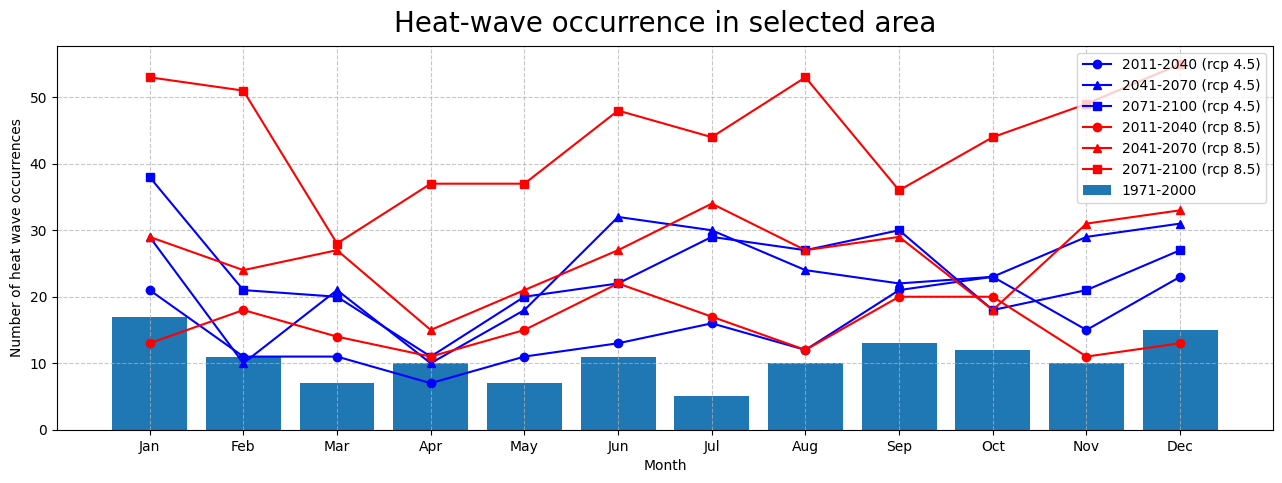

In [13]:
# This code plots the results for the selected point 
#list_values= [pixel_values_p1m, pixel_values_p2m, pixel_values_p3m]
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
bar = pixel_values_hm
line1 = pixel_values_p1m_45
line2 = pixel_values_p2m_45
line3 = pixel_values_p3m_45
line4 = pixel_values_p1m_85
line5 = pixel_values_p2m_85
line6 = pixel_values_p3m_85
fig, ax = plt.subplots()
ax.bar(month, bar, label='1971-2000')
ax.plot(month, line1, color='blue', marker='o', label='2011-2040 (rcp 4.5)')
ax.plot(month, line2, color='blue', marker="^", label='2041-2070 (rcp 4.5)')
ax.plot(month, line3, color='blue', marker='s', label='2071-2100 (rcp 4.5)')
ax.plot(month, line4, color='red', marker='o', label='2011-2040 (rcp 8.5)')
ax.plot(month, line5, color='red', marker="^", label='2041-2070 (rcp 8.5)')
ax.plot(month, line6, color='red', marker='s', label='2071-2100 (rcp 8.5)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of heatwave occurrences')
ax.set_title('heatwave occurrence in selected area', fontsize=20, pad=10)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.1, bottom=0.1, right=2, top=0.9)
plt.show()

- This graph compares the heatwave occurrence for month of years 1971-2000 and 2011-2040, 2041-2070, 2071-2100 for RCP 4.5 and 8.5
- The heatwave occurrence for months is based on the 90-percentile treshold for each month from reference period 1971-2000. This treshold was used for all projection periods. That's why we can also find heatwaves in the winter and autumn months. We should understand the heatwave occurrence in the winter and autumn months, as a periods when the daily maximum temperature exceeds the 90th percentile temperature threshold computed for the given month from 30 years reference (historical) period 1971-2000.
- These results give us an idea of heatwave distribution throughout the year in the past and in the near and far future for different scenarios RCPs
- We need to also realize that the heat occurrence in the winter will have a different impact than the heat occurrence in the summer. The winter heat occurrence can influence the of the snow, animals, and plants for more see [[Heat effects on human nature](https://theconversation.com/four-ways-winter-heatwaves-affect-humans-and-nature-197365)]. The summer heatwaves will have a negative effect on the human health, water scarcity etc. [[Climate adapt effect on human health](https://climate-adapt.eea.europa.eu/en/knowledge/tools/urban-adaptation/climatic-threats/heatwaves)]

### Plot the comparison by years for the selected location

We compare the heatwave occurrence in the observed period (1971-2000) and projection (2011-2100) for chosen climate scenario. We selected these periods because these are the most used climate periods by CDS. 

- On this graph you can see the heatwave occurence for the reference period 1971-2000 and projection periods 2011-2100
- The number of heatwave occurence for each year represents the the sum of the heat have occurence for each year (also winter and autumn months)

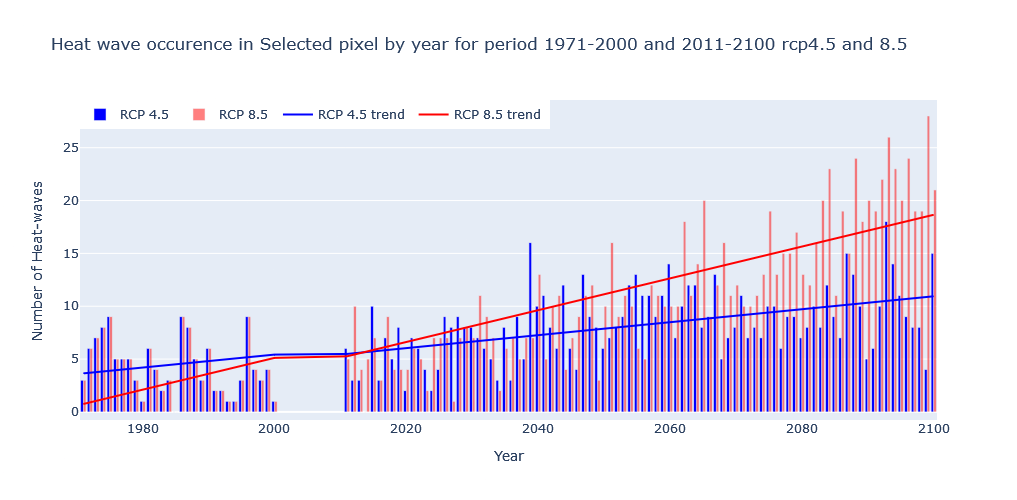

In [33]:
# This code plots the heatwave occurrence for the selected point for years 
# Sample data
b = pixel_values_hy + pixel_values_p1y_45 + pixel_values_p2y_45 + pixel_values_p3y_45
t = pixel_values_hy + pixel_values_p1y_85 + pixel_values_p2y_85 + pixel_values_p3y_85

# Define years
yearh = list(range(1971, 2001))
yearp1 = list(range(2011, 2101))
year = yearh + yearp1
# Create figure
fig = go.Figure()
# Add bar trace for 'b'
fig.add_trace(go.Bar(x=year, y=b, name='RCP 4.5', marker_color='blue'))
# Add bar trace for 't'
fig.add_trace(go.Bar(x=year, y=t, name='RCP 8.5', opacity=0.5, marker_color='red'))
# Update layout
fig.update_layout(
    title='Yearly heatwave occurence in selected location by year for period 1971-2000 and 2011-2100 RCP4.5 and RCP8.5',
    xaxis_title='Year',
    yaxis_title='Number of heatwaves',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=1100,
    height=500)

## Step 4: Conclusion for Peseta IV results

Monthly comparison shows in which months we can expect the highest increase in the heatwave occurrence. Yearly comparisons show that the trend of heatwave occurrence should rise, however, how steep the trendline will be depends on the climate scenario and area you choose. 

## Authors

Main contributors:
- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)